In [72]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

In [2]:
conn = sqlite3.connect('workshop.db')

## Weekly matches

In [3]:
df = pd.read_sql_query('''SELECT 
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    COUNT(*) AS MatchCount
FROM MatchStats
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND EXISTS (
        SELECT 1
        FROM json_each(Players) AS player
        WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    )
GROUP BY WeekStartDate
ORDER BY WeekStartDate;''', conn)

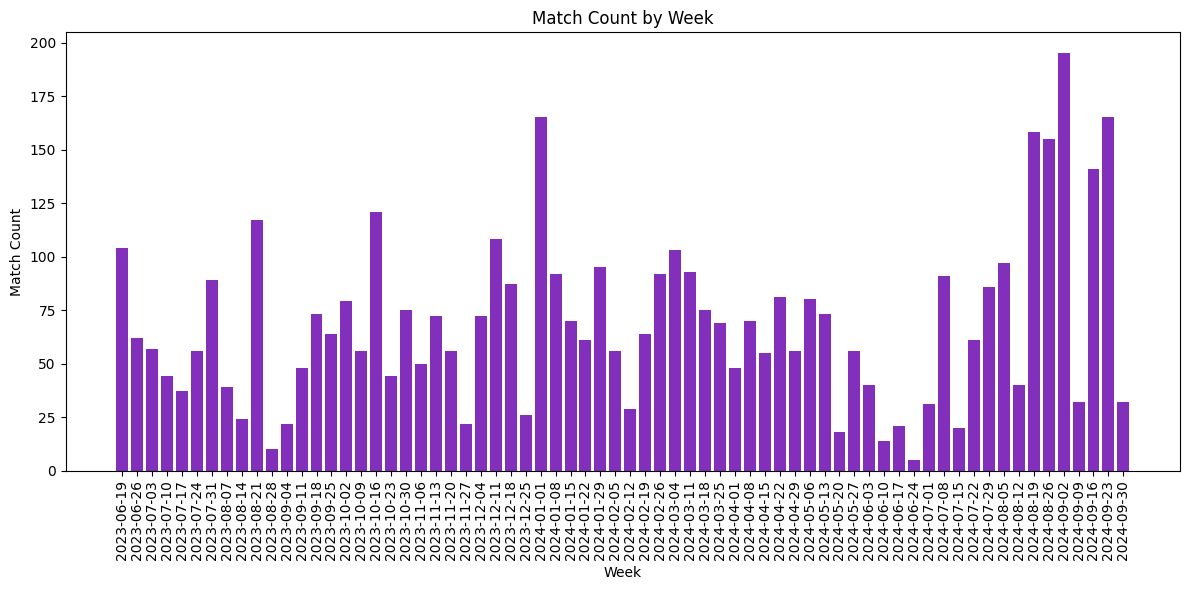

In [4]:
plt.figure(figsize=(12, 6))
plt.bar(df['WeekStartDate'], df['MatchCount'], color='#822fbb')
plt.xlabel('Week')
plt.ylabel('Match Count')
plt.title('Match Count by Week')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to make room for x-axis labels

# Show the chart
plt.show()

## Monthly matches

In [9]:
df = pd.read_sql_query('''SELECT 
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS YearMonth,
    COUNT(*) AS MatchCount
FROM MatchStats
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND EXISTS (
        SELECT 1
        FROM json_each(Players) AS player
        WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    )
GROUP BY YearMonth
ORDER BY YearMonth;
''', conn)

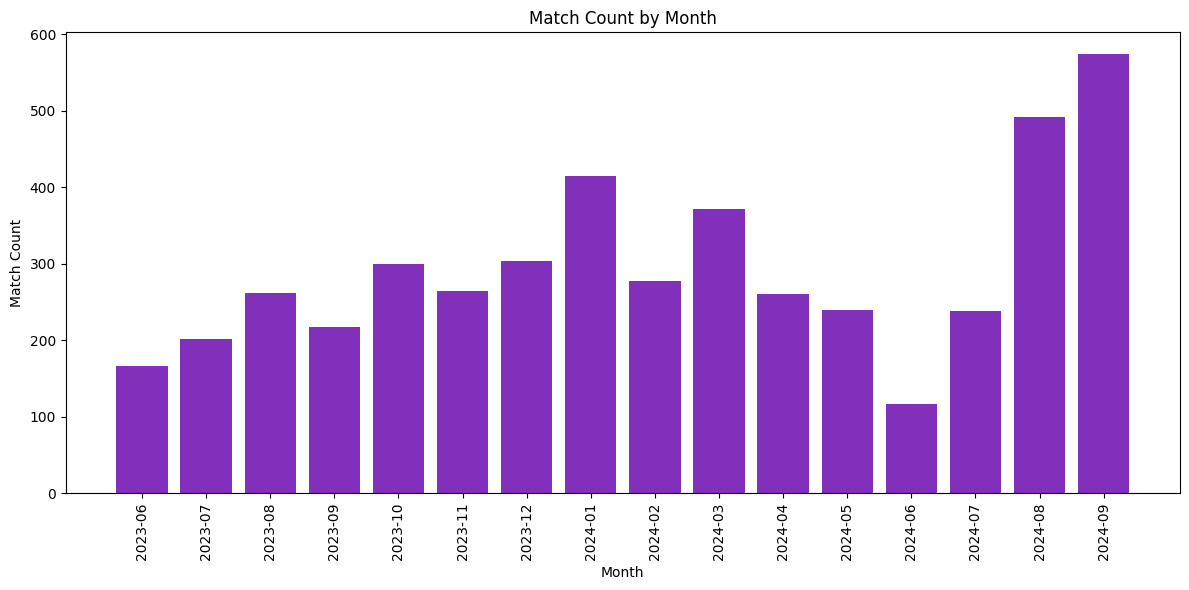

In [10]:
plt.figure(figsize=(12, 6))
plt.bar(df['YearMonth'], df['MatchCount'], color='#822fbb')
plt.xlabel('Month')
plt.ylabel('Match Count')
plt.title('Match Count by Month')
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to make room for x-axis labels

# Show the chart
plt.show()

## Players I played with

In [14]:
df = pd.read_sql_query('''WITH PlayerTeam AS (
    SELECT 
        MatchId, 
        json_extract(player.value, '$.LastTeamId') AS TeamId
    FROM MatchStats, json_each(Players) AS player
    WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
)
SELECT 
    json_extract(otherPlayer.value, '$.PlayerId') AS PlayerId,
    COUNT(DISTINCT MatchStats.MatchId) AS UniqueMatchCount
FROM MatchStats, json_each(Players) AS otherPlayer
WHERE 
    MatchStats.MatchId IN (SELECT MatchId FROM PlayerTeam) 
    AND json_extract(otherPlayer.value, '$.LastTeamId') = (SELECT TeamId FROM PlayerTeam WHERE PlayerTeam.MatchId = MatchStats.MatchId)
GROUP BY PlayerId
ORDER BY UniqueMatchCount DESC
''', conn)

df.head(10)

,PlayerId,UniqueMatchCount
0,xuid(2533274855333605),4699
1,xuid(2676022814299645),195
2,xuid(2535450430228717),175
3,xuid(2535461171399845),35
4,xuid(2689426384619306),34
5,xuid(2533274961303003),22
6,bid(45.0),19
7,xuid(2533274796148096),18
8,bid(51.0),16
9,bid(49.0),16


## Players I played against

In [15]:
df = pd.read_sql_query('''WITH PlayerTeam AS (
    SELECT 
        MatchId, 
        json_extract(player.value, '$.LastTeamId') AS TeamId
    FROM MatchStats, json_each(Players) AS player
    WHERE json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00'
)
SELECT 
    json_extract(otherPlayer.value, '$.PlayerId') AS PlayerId,
    COUNT(DISTINCT MatchStats.MatchId) AS UniqueMatchCount
FROM MatchStats, json_each(Players) AS otherPlayer
WHERE 
    MatchStats.MatchId IN (SELECT MatchId FROM PlayerTeam) 
    AND json_extract(otherPlayer.value, '$.LastTeamId') != (SELECT TeamId FROM PlayerTeam WHERE PlayerTeam.MatchId = MatchStats.MatchId)
GROUP BY PlayerId
ORDER BY UniqueMatchCount DESC
''', conn)

df.head(10)

,PlayerId,UniqueMatchCount
0,bid(0.0),26
1,bid(55.0),22
2,bid(27.0),22
3,bid(23.0),22
4,xuid(2535445394664181),21
5,xuid(2535450430228717),20
6,bid(5.0),20
7,bid(4.0),19
8,bid(13.0),19
9,bid(52.0),18


## Games in progress I've joined

In [40]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = true
GROUP BY WeekStartDate, Outcome
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

,Matches,WeekStartDate,Outcome
0,3,2023-06-19,3
1,2,2023-06-26,2
2,2,2023-06-26,3
3,2,2023-07-03,2
4,2,2023-07-03,3
5,1,2023-07-03,4
6,1,2023-07-10,2
7,4,2023-07-10,3
8,1,2023-07-17,2
9,4,2023-07-31,2


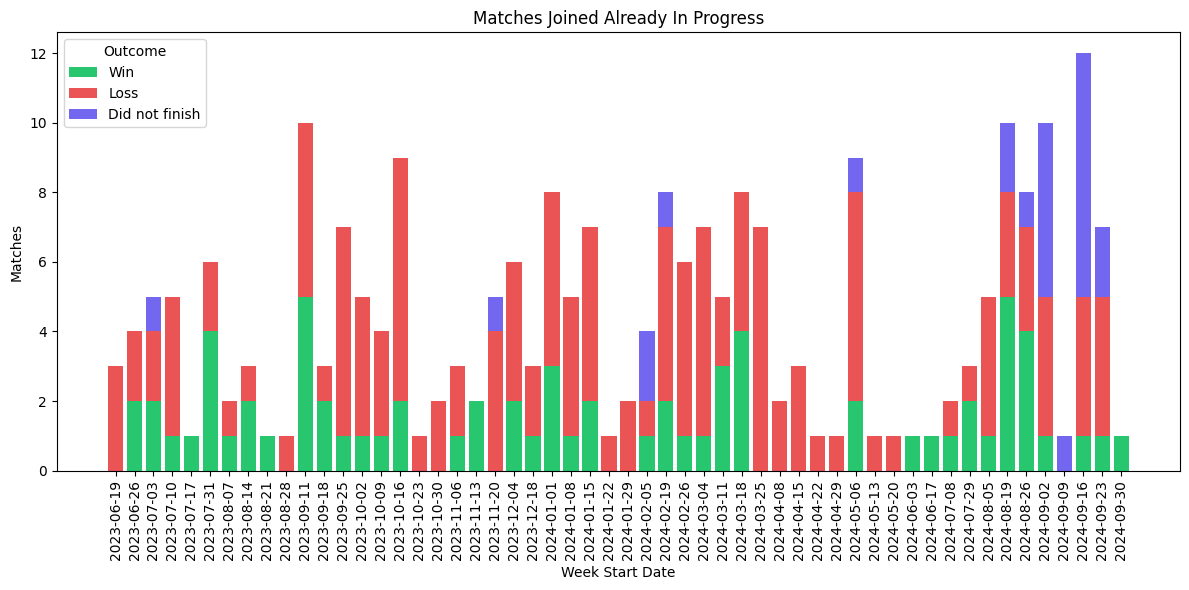

In [41]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

# Assuming df is your DataFrame from the SQL query result

# Create a DataFrame for stacking
stacked_data = df.pivot_table(index='WeekStartDate', columns='Outcome', values='Matches', fill_value=0)

# Create a bar chart
plt.figure(figsize=(12, 6))

# Initialize the bottom variable for stacking
bottom_values = [0] * len(stacked_data)

# Loop through each outcome and plot the bars
for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)
        # Update the bottom values for stacking
        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]

# Labeling and formatting
plt.xlabel('Week Start Date')
plt.ylabel('Matches')
plt.title('Matches Joined Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

# Move the legend to the upper left corner
plt.legend(title='Outcome', loc='upper left')

# Show the chart
plt.show()

In [43]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS YearMonth,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.JoinedInProgress') = true
GROUP BY YearMonth, Outcome
ORDER BY YearMonth ASC;
''', conn)

df.head(10)

,Matches,YearMonth,Outcome
0,2,2023-06,2
1,5,2023-06,3
2,5,2023-07,2
3,6,2023-07,3
4,1,2023-07,4
5,7,2023-08,2
6,4,2023-08,3
7,8,2023-09,2
8,13,2023-09,3
9,4,2023-10,2


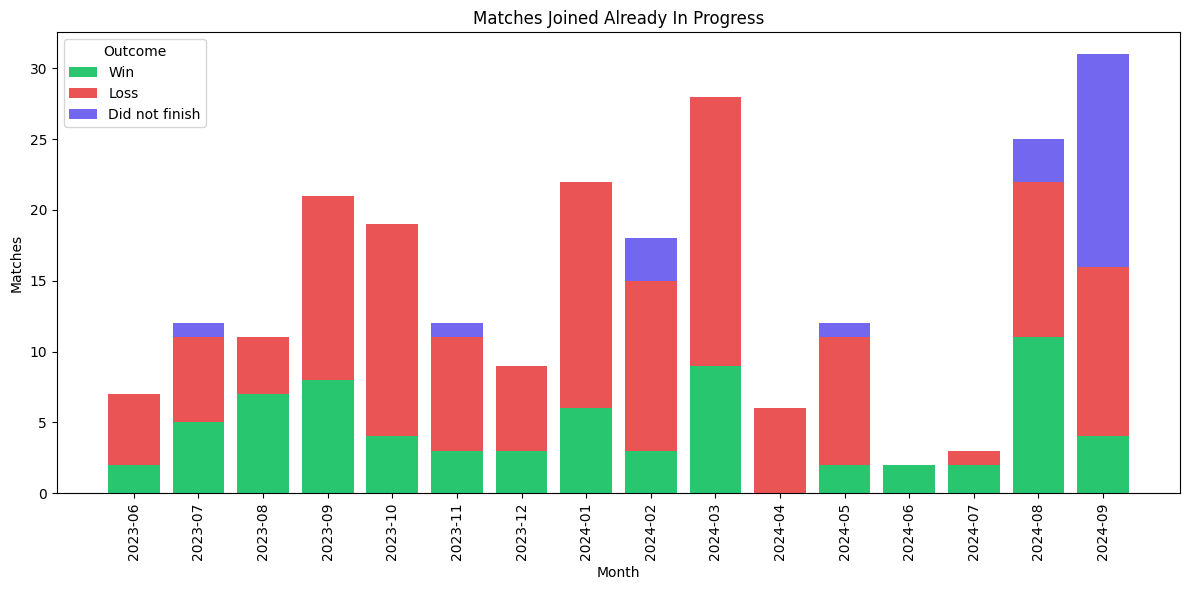

In [44]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

# Assuming df is your DataFrame from the SQL query result

# Create a DataFrame for stacking
stacked_data = df.pivot_table(index='YearMonth', columns='Outcome', values='Matches', fill_value=0)

# Create a bar chart
plt.figure(figsize=(12, 6))

# Initialize the bottom variable for stacking
bottom_values = [0] * len(stacked_data)

# Loop through each outcome and plot the bars
for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)
        # Update the bottom values for stacking
        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]

# Labeling and formatting
plt.xlabel('Month')
plt.ylabel('Matches')
plt.title('Matches Joined Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

# Move the legend to the upper left corner
plt.legend(title='Outcome', loc='upper left')

# Show the chart
plt.show()

## Games in progress I left

In [49]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    date(datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime', 'weekday 0', '-6 days')) AS WeekStartDate,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.LeftInProgress') = true
GROUP BY WeekStartDate, Outcome
ORDER BY WeekStartDate ASC;
''', conn)

df.head(10)

,Matches,WeekStartDate,Outcome
0,1,2023-07-03,4
1,1,2023-07-24,4
2,1,2023-07-31,4
3,1,2023-08-21,4
4,1,2023-09-18,4
5,2,2023-09-25,4
6,1,2023-10-02,4
7,3,2023-10-16,4
8,4,2023-10-30,4
9,3,2023-11-06,4


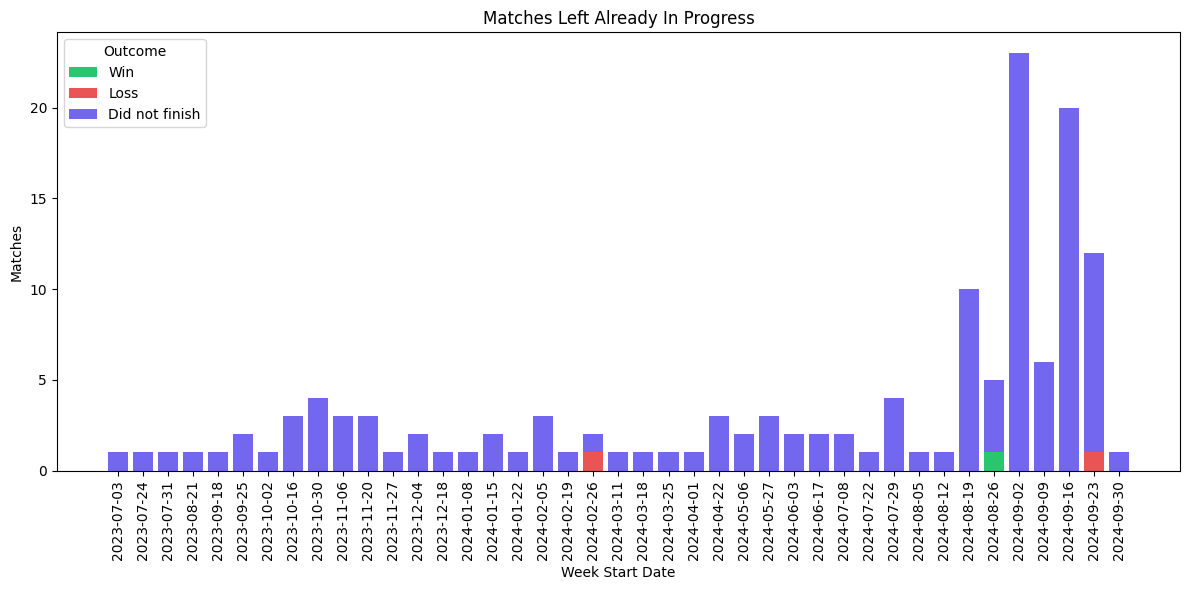

In [50]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

# Assuming df is your DataFrame from the SQL query result

# Create a DataFrame for stacking
stacked_data = df.pivot_table(index='WeekStartDate', columns='Outcome', values='Matches', fill_value=0)

# Create a bar chart
plt.figure(figsize=(12, 6))

# Initialize the bottom variable for stacking
bottom_values = [0] * len(stacked_data)

# Loop through each outcome and plot the bars
for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)
        # Update the bottom values for stacking
        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]

# Labeling and formatting
plt.xlabel('Week Start Date')
plt.ylabel('Matches')
plt.title('Matches Left Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

# Move the legend to the upper left corner
plt.legend(title='Outcome', loc='upper left')

# Show the chart
plt.show()

In [51]:
df = pd.read_sql_query('''SELECT
	COUNT(DISTINCT MatchId) Matches,
    strftime('%Y-%m', datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime')) AS YearMonth,
    json_extract(player.value, '$.Outcome') AS Outcome
FROM MatchStats, json_each(Players) AS player
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
	AND json_extract(player.value, '$.ParticipationInfo.LeftInProgress') = true
GROUP BY YearMonth, Outcome
ORDER BY YearMonth ASC;
''', conn)

df.head(10)

,Matches,YearMonth,Outcome
0,2,2023-07,4
1,2,2023-08,4
2,3,2023-09,4
3,4,2023-10,4
4,11,2023-11,4
5,3,2023-12,4
6,4,2024-01,4
7,1,2024-02,3
8,5,2024-02,4
9,3,2024-03,4


In [ ]:
outcome_info = {
    1: {'label': 'Tie', 'color': '#7367F0'},
    2: {'label': 'Win', 'color': '#28C76F'},
    3: {'label': 'Loss', 'color': '#EA5455'},
    4: {'label': 'Did not finish', 'color': '#7367F0'}
}

# Assuming df is your DataFrame from the SQL query result

# Create a DataFrame for stacking
stacked_data = df.pivot_table(index='YearMonth', columns='Outcome', values='Matches', fill_value=0)

# Create a bar chart
plt.figure(figsize=(12, 6))

# Initialize the bottom variable for stacking
bottom_values = [0] * len(stacked_data)

# Loop through each outcome and plot the bars
for outcome, info in outcome_info.items():
    if outcome in stacked_data.columns:
        plt.bar(stacked_data.index, stacked_data[outcome], 
                color=info['color'], 
                label=info['label'], 
                bottom=bottom_values)
        # Update the bottom values for stacking
        bottom_values = [bottom + stacked_data[outcome].values[i] for i, bottom in enumerate(bottom_values)]

# Labeling and formatting
plt.xlabel('Month')
plt.ylabel('Matches')
plt.title('Matches Left Already In Progress')
plt.xticks(rotation=90)
plt.tight_layout()

# Move the legend to the upper left corner
plt.legend(title='Outcome', loc='upper left')

# Show the chart
plt.show()

## Maps I quit the match on

In [57]:
df = pd.read_sql_query('''SELECT
    COUNT(DISTINCT MatchId) AS Matches,
    json_extract(MatchInfo, '$.MapVariant.AssetId') AS AssetId,
    Maps.PublicName
FROM MatchStats, json_each(Players) AS player
JOIN Maps ON json_extract(MatchInfo, '$.MapVariant.AssetId') = Maps.AssetId  -- Join on AssetId
WHERE 
    datetime(json_extract(MatchInfo, '$.StartTime'), 'localtime') > '2023-06-20 11:00:00' 
    AND json_extract(MatchInfo, '$.LifecycleMode') = 3
    AND json_extract(player.value, '$.PlayerId') = 'xuid(2533274855333605)'
    AND json_extract(player.value, '$.ParticipationInfo.LeftInProgress') = true
GROUP BY AssetId, Maps.PublicName  -- Group by AssetId and PublicName
ORDER BY Matches DESC;
''', conn)

df.head(10)

,Matches,AssetId,PublicName
0,49,525451ca-0bfa-4b5c-8a0f-29524e0f2834,Disciple
1,12,2c9df7e9-89e7-430a-8615-32474d4617c1,Formation
2,5,8be179f7-8940-4868-b881-44cad1ca8711,Corpo
3,5,aab54656-a45c-4724-8205-6778ae62db64,Ronin
4,4,1612a412-a7bc-49eb-829f-cea9d537052d,Scarlett's Landing
5,4,37a9b5f0-6be7-4a46-8010-1fe6f7ea5611,Ruujaya
6,4,50a1a3b5-c54d-4e40-8744-b92051d48897,Diminished
7,4,88d45250-97dd-4a28-8fb2-b52baaeebb39,Pharaoh
8,3,2bfd7643-1091-40b1-a889-2c5fc6367c25,Smallhalla
9,3,c395f3ac-4614-45f9-a83a-56f69e8ae962,Aquarius


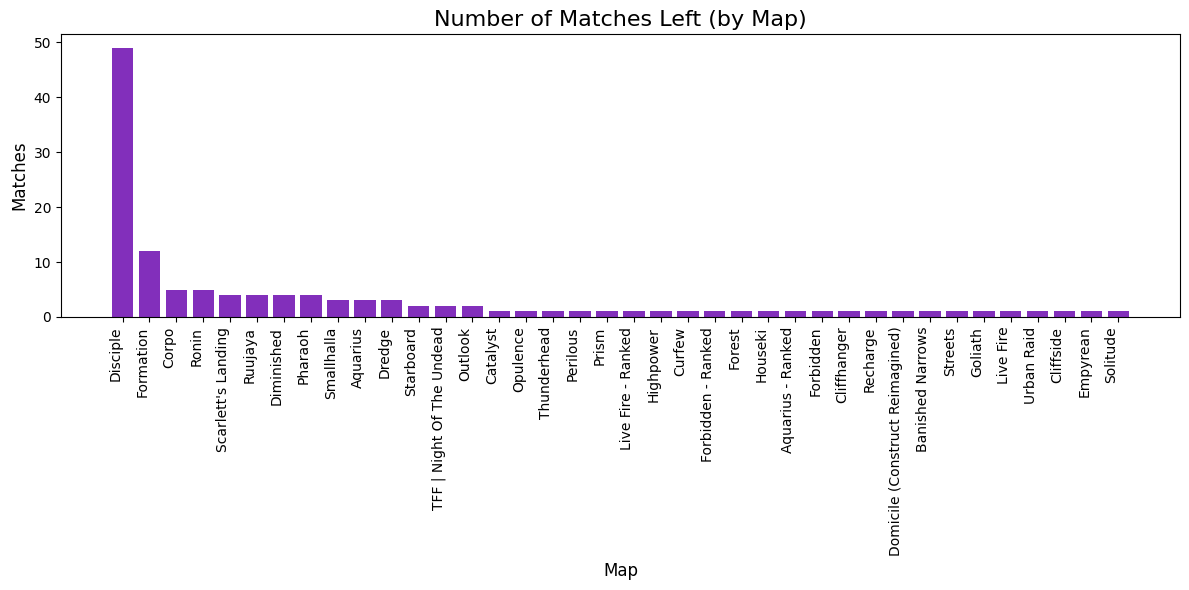

In [81]:
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(df['PublicName'], df['Matches'], color='#822fbb')  # Create bars

# Adding titles and labels
plt.title('Number of Matches Left (by Map)', fontsize=16)
plt.xlabel('Map', fontsize=12)
plt.ylabel('Matches', fontsize=12)
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability

# Show the chart
plt.tight_layout()  # Adjust layout to make room for labels
plt.show()